# Face Representation and Similarity through Clustering and Dimensionality Reduction 

## Objective

The primary objective of this project is to use dimensionality reduction and unsupervised clustering techniques for effective face similarity analysis using the Labeled Faces in the Wild (LFW) dataset. <br>
GOAL:
* Reduce the high-dimensional face image space into compact feature representations.
* Apply clustering methods to discover natural groupings of identities.
* Evaluate similarity between faces using distance and similarity measures.
* Compare the effectiveness of different algorithms.

## Stakeholder Benefits

* Security & Biometrics: A lightweight, interpretable alternative for face grouping and retrieval without large-scale neural networks, methods for facial data, relevant for low-resource settings.

### importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

### getting the dataset

In [2]:
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
X = lfw.data           
images = lfw.images      
y = lfw.target
target_names = lfw.target_names
n_samples, n_features = X.shape
h, w = images[0].shape

print(f"Loaded LFW: {n_samples} samples, each {h}x{w} ({n_features} features).")
print(f"Number of distinct people: {len(target_names)}")

Loaded LFW: 1560 samples, each 50x37 (1850 features).
Number of distinct people: 12


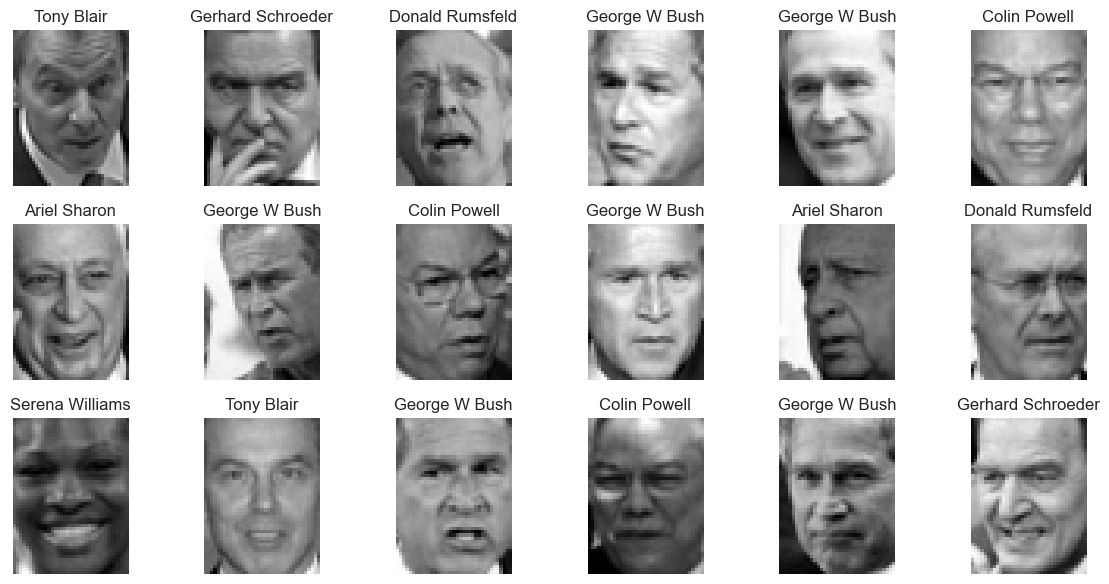

Top 10 identities by sample count:
George W Bush        530
Colin Powell         236
Tony Blair           144
Donald Rumsfeld      121
Gerhard Schroeder    109
Ariel Sharon          77
Hugo Chavez           71
Junichiro Koizumi     60
Jean Chretien         55
John Ashcroft         53
Name: count, dtype: int64


In [3]:
fig, axes = plt.subplots(3,6, figsize=(12,6))
axes = axes.ravel()
for i in range(18):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(target_names[y[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

counts = pd.Series(y).map(lambda v: target_names[v]).value_counts()
print('Top 10 identities by sample count:')
print(counts.head(10))

### preprocessing

In [4]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print('mean (first 5 features):', X_std[:, :5].mean(axis=0))
print('std  (first 5 features):', X_std[:, :5].std(axis=0))

mean (first 5 features): [-1.2685091e-08 -5.3491349e-09  6.5717942e-09 -4.2028918e-09
 -5.3491349e-09]
std  (first 5 features): [1.0000005  0.9999998  0.99999976 1.0000005  0.99999976]


### PCA

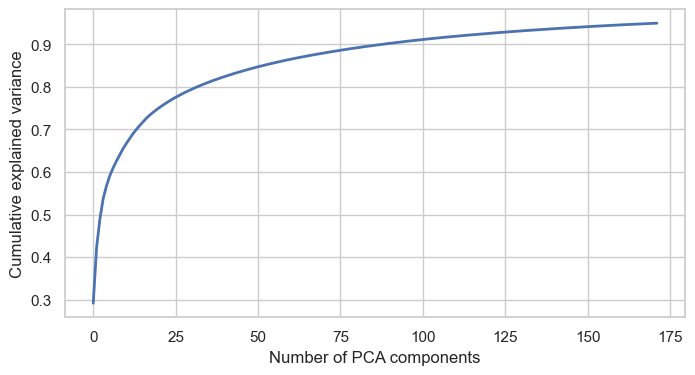

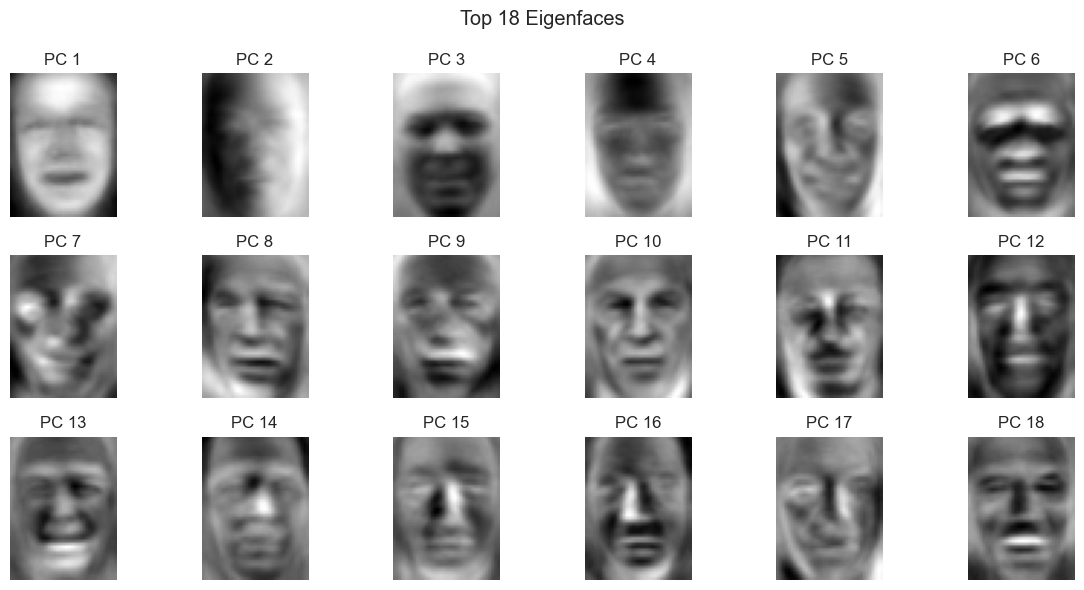

In [7]:
pca_full = PCA(svd_solver='full', random_state=42)
pca_full.fit(X_std)
explained = np.cumsum(pca_full.explained_variance_ratio_)

target_variance = 0.95 
n_components = np.argmax(explained >= target_variance) + 1

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=42)
X_pca = pca.fit_transform(X_std)

explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(explained, linewidth=2)
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)

eigenfaces = pca.components_.reshape((n_components, h, w))
fig, axes = plt.subplots(3,6, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    if i < 18:
        ax.imshow(eigenfaces[i], cmap='gray')
        ax.set_title(f'PC {i+1}')
        ax.axis('off')
plt.suptitle('Top 18 Eigenfaces')
plt.tight_layout()
plt.show()

### TSNE

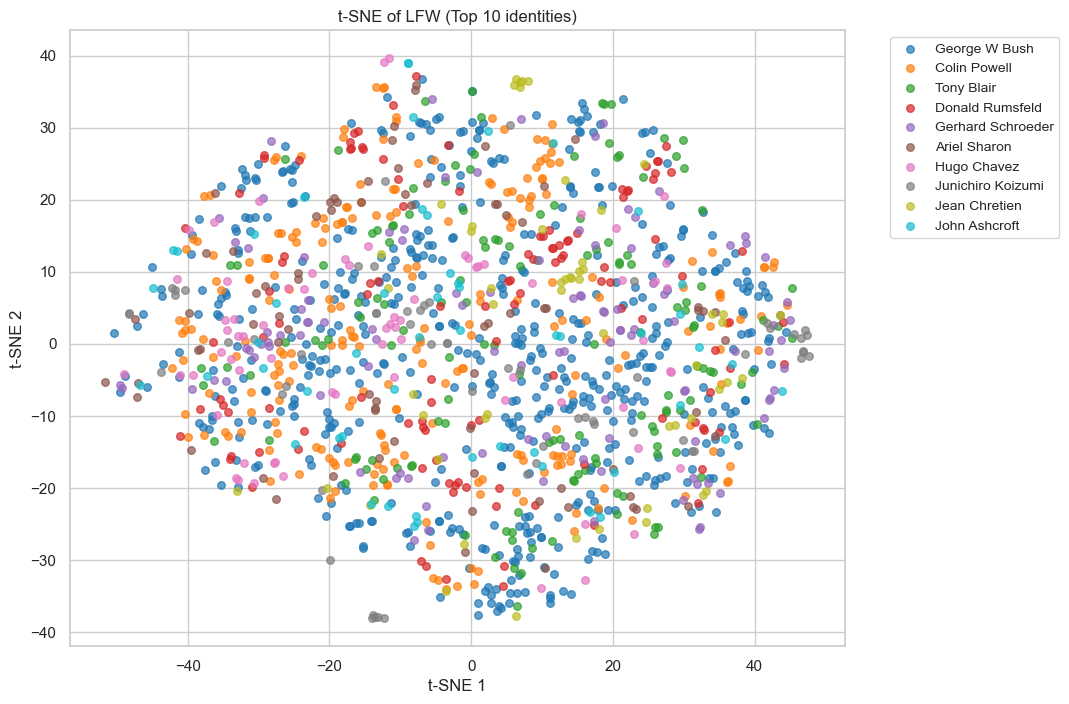

In [9]:
pca_50 = PCA(n_components=50, svd_solver='randomized', random_state=42)
X_pca50 = pca_50.fit_transform(X_std)


tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,   
    random_state=42,
    init='pca'
)
X_tsne = tsne.fit_transform(X_pca50)

counts = pd.Series(y).map(lambda v: target_names[v]).value_counts()
top_names = counts.head(10).index.tolist()
top_indices = [i for i, label in enumerate(y) if target_names[label] in top_names]

X_tsne_top = X_tsne[top_indices]
y_top = y[top_indices]
names_top = [target_names[label] for label in y_top]

palette = sns.color_palette("tab10", n_colors=len(top_names))
name_to_color = {name: palette[i] for i, name in enumerate(top_names)}
colors_top = [name_to_color[name] for name in names_top]

plt.figure(figsize=(10,8))
for name in top_names:
    idx = [i for i, n in enumerate(names_top) if n == name]
    plt.scatter(X_tsne_top[idx,0], X_tsne_top[idx,1], s=30, alpha=0.7, label=name, color=name_to_color[name])

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.title('t-SNE of LFW (Top 10 identities)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()


## Clustering

Run KMeans, Agglomerative, and DBSCAN on PCA features and evaluate vs ground truth (labels) with ARI and NMI.

In [10]:
X_feat = X_pca  

# KMeans
k = len(target_names)
kmeans = KMeans(n_clusters=k, random_state=42)
klabels = kmeans.fit_predict(X_feat)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=k)
alabels = agg.fit_predict(X_feat)

# DBSCAN 
db = DBSCAN(eps=3, min_samples=5)
dlabels = db.fit_predict(X_feat)

# Evaluate
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def eval_labels(true, pred, name):
    ari = adjusted_rand_score(true, pred)
    nmi = normalized_mutual_info_score(true, pred)
    print(f"{name}: ARI={ari:.4f}, NMI={nmi:.4f}")

print('Evaluating clustering against true labels (note: unsupervised clustering will rarely match perfectly)')
eval_labels(y, klabels, 'KMeans')
eval_labels(y, alabels, 'Agglomerative')
eval_labels(y, dlabels, 'DBSCAN')

C:\Users\Rishwanth J V K\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Evaluating clustering against true labels (note: unsupervised clustering will rarely match perfectly)
KMeans: ARI=0.0566, NMI=0.0681
Agglomerative: ARI=0.0354, NMI=0.0978
DBSCAN: ARI=0.0000, NMI=0.0000


## Similarity Checking — Verification & Retrieval

We use cosine similarity on PCA features for retrieval and simple verification thresholds.

Query identity: Ariel Sharon
Neighbor identities and scores:
 - George W Bush: 0.378
 - George W Bush: 0.285
 - Colin Powell: 0.237
 - George W Bush: 0.217
 - Hugo Chavez: 0.186
 - Ariel Sharon: 0.183


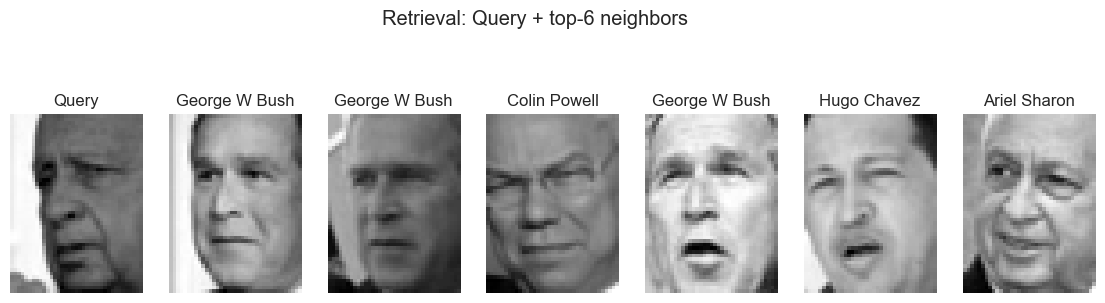

In [11]:
sim = cosine_similarity(X_feat)

def retrieve_similar(i, k=5):
    sims = sim[i]
    idx = np.argsort(-sims)
    idx = idx[idx != i]
    return idx[:k], sims[idx[:k]]

query_idx = 10
neighbors, scores = retrieve_similar(query_idx, k=6)
print('Query identity:', target_names[y[query_idx]])
print('Neighbor identities and scores:')
for n,s in zip(neighbors, scores):
    print(f" - {target_names[y[n]]}: {s:.3f}")

fig, axes = plt.subplots(1, 7, figsize=(14,4))
axes[0].imshow(images[query_idx], cmap='gray')
axes[0].set_title('Query')
axes[0].axis('off')
for i, n in enumerate(neighbors):
    axes[i+1].imshow(images[n], cmap='gray')
    axes[i+1].set_title(target_names[y[n]])
    axes[i+1].axis('off')
plt.suptitle('Retrieval: Query + top-6 neighbors')
plt.show()

### Retrieval evaluation (Precision@k)

Compute precision@k: fraction of top-k retrieved that have same identity as query.

In [12]:
def precision_at_k(k=5):
    ps = []
    for i in range(len(X_feat)):
        neighbors, _ = retrieve_similar(i, k=k)
        ps.append((y[neighbors] == y[i]).mean())
    return np.mean(ps)

for k in [1,3,5,10]:
    print(f'Precision@{k}: {precision_at_k(k):.4f}')

Precision@1: 0.7731
Precision@3: 0.6972
Precision@5: 0.6458
Precision@10: 0.5526


## Conclusion & Next steps

**Summary:**
- We constructed a lightweight pipeline using PCA for feature extraction, t-SNE for visualization, multiple clustering algorithms for unsupervised grouping, and cosine-similarity for retrieval/verification.

**Next steps / Extensions:**
- Use learned embeddings (e.g., from pre-trained face models) for stronger baselines — *only if allowed*.
- Explore metric learning (e.g., PCA + LDA or classical pairwise metric learning) without deep nets.
- Analyze failure cases, demographic balance, and cluster purity per identity.

---